# Clipped Hyperbolic Classifiers Are Super-Hyperbolic Classifiers

Welcome to our fourth notebook for the ECCV 2022 Tutorial "[Hyperbolic Representation Learning for Computer Vision](https://sites.google.com/view/hyperbolic-tutorial-eccv22)"!

**Open notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/MinaGhadimiAtigh/hyperbolic_representation_learning/blob/main/notebooks/4_Clipped_Hyperbolic_Classifiers_Are_Super_Hyperbolic_Classifiers.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MinaGhadimiAtigh/hyperbolic_representation_learning/blob/main/notebooks/4_Clipped_Hyperbolic_Classifiers_Are_Super_Hyperbolic_Classifiers.ipynb)  

**Author:** Mina Ghadimi Atigh

In this tutorial, you will go through [Clipped Hyperbolic Classifiers Are Super-Hyperbolic Classifiers](https://openaccess.thecvf.com/content/CVPR2022/papers/Guo_Clipped_Hyperbolic_Classifiers_Are_Super-Hyperbolic_Classifiers_CVPR_2022_paper.pdf), CVPR 2022 paper.

While many datasets and labels are hierarchical in nature, Euclidean space is suboptimal in learning the hierarchical structures. Hyperbolic space is a non-Euclidean space with constant negative curvature. As moving from the origin towards the boundary, the distances grow exponentially, as in hierarchical structures. When the dataset contains a known hierarchical structure, projecting the Euclidean features to hyperbolic space improves the performance. Hyperbolic neural networks. However, HNN suffers from several limitations. 
<ul>
<li> HNN underperforms ENN when the dataset does not have a hierarchical structure. </li>
<li> There are some limitations even when the dataset contains hierarchical structure. </li>
<li> HNNs performance on tandard benchmarks is not investigated. </li>
</ul>

Here you can see an example of a hybrid HNN, in which the embedding of the input is extracted with an ENN as the first step. Then, the embedding is projected to the hyperbolic space using Exponential Map and loss function.

<center width="100%"><img src="figures/4_fig1.png"></center>

## Vanishing gradients is the problem in hybrid HNN!

The goal is to find out why HNNs underperform ENNs in some cases. The key element may be backpropagating the **gradients** from the hyperbolic space to the Euclidean space. So let's look at how gradients are calculated. 

\begin{align}
\frac{\partial \ell}{\partial w^E} = (\frac{\partial x^H}{\partial w^E})^T\frac{\partial \ell}{\partial x^H}
\end{align}

where $x^E$ and $x^H$ are the Euclidean and Hyperbolic embeddings of the input $x$. $\frac{\partial \ell}{\partial x^H}$ in the gradient of the loss function $\ell$ with respect to the hyperbolic embedding $x^H$, which is the Riemannian gradient,

\begin{align}
\frac{\partial \ell}{\partial x^H} = \frac{(1 - \|x^H\|^2)^2}{4} \nabla\ell(x^H)
\end{align}

where $\nabla\ell(x^H)$ is the Euclidean gradient.

During training and learning embeddings in hyperbolic space, the points move to the boundary of the hyperbolic space, resulting in $\|x^H\|^2$ getting close to $1$. Consequently, the gradient diminishes during training, which indicates vanishing gradients as a problem occurring during the training of a hybrid HNN.

## How can we avoid vanishing gradients?
Since approaching the boundary of hyperbolic space causes problems in training, one solution may be to impose a soft regularization on the Euclidean embedding before the exponential map so that the norm of the embedding does not exceed a certain threshold.

\begin{align}
CLIP(x^E; r) = min\{1, \frac{r}{\|x^E\|}\} . x^E
\end{align}

where r is a hyperparameter. Also, clipped hyperbolic embedding will be $CLIP(x^H;r) = Exp_0^c(CLIP(x^E;r))$.


As a result of clipping, hyperbolic embeddings will not lie throughout the hyperbolic space. Here you can see the clipped hybrid HNN.

<center width="100%"><img src="figures/4_fig2.png"></center>

Here, you can find out the implementation of clipping, applied on top of Euclidean embedding. `clip(input_vector, r)` gets the Euclidean embedding and r which is the hyperparameter and outputs the clipped Euclidean embedding vector.

In [1]:
def clip(input_vector, r):
    input_norm = torch.norm(input_vector, dim = -1)
    clip_value = float(r)/input_norm
    min_norm = torch.clamp(float(r)/input_norm, max = 1)
    return min_norm[:, None] * input_vector

## Clipped Hyperbolic Embeddings

To check how the clipping affects the performance of HNN, we will go through [Notebook2, Hyperbolic Image Embessings](https://github.com/MinaGhadimiAtigh/hyperbolic_representation_learning/blob/main/notebooks/2_Hyperbolic_Image_Embeddings.ipynb). Everything is same as Notebook2 and the only difference is feeding the clipped Euclidean features to the hyperbolic space.

Let's start with importing libraries, setting manual seed and downloading *CUB-200-2011* Dataset.

In [2]:
!wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/6633edbbeffd6d90271f0963852a046c64f407d6/examples/fewshot/networks/convnet.py
!pip install -q git+https://github.com/geoopt/geoopt.git

In [3]:
## standard libraries
import numpy as np
import os
import PIL
from PIL import Image
from PIL import ImageEnhance
import random
import warnings

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## PyTorch Torchvision
import torchvision
from torchvision import transforms

## geoopt for hyperbolic  
import geoopt

## Neural network downloaded from paper's GitHub
from convnet import ConvNet

warnings.filterwarnings('ignore')

In [4]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [5]:
from IPython.display import clear_output 
%mkdir data
%mkdir data/cub
%cd data/cub
!wget -q -O tmp.tgz https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1
!tar -xzvf tmp.tgz
!rm tmp.tgz
!rm attributes.txt
%mkdir images
!mv CUB_200_2011/images/*/*.jpg images
!mv CUB_200_2011/classes.txt classes.txt
!rm -r CUB_200_2011
clear_output()

%mkdir split
%cd split
![ ! -f test.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/test.csv
![ ! -f val.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/val.csv
![ ! -f train.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/train.csv
%cd ../../..

mkdir: cannot create directory ‘split’: File exists
/home/mina/workspace/hyperbolic_representation_learning/notebooks/data/cub/split
/home/mina/workspace/hyperbolic_representation_learning/notebooks


The next step is to handle data loader functions.

In [5]:
# ROOT to the images and split, data files are available here.
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data/cub/")
IMAGE_PATH = os.path.join(DATA_PATH, "images")
SPLIT_PATH = os.path.join(DATA_PATH, "split")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
transformtypedict = dict(
    Brightness=ImageEnhance.Brightness,
    Contrast=ImageEnhance.Contrast,
    Sharpness=ImageEnhance.Sharpness,
    Color=ImageEnhance.Color,
)


class ImageJitter(object):
    def __init__(self, transformdict):
        self.transforms = [(transformtypedict[k], transformdict[k]) for k in transformdict]

    def __call__(self, img):
        out = img
        randtensor = torch.rand(len(self.transforms))
        for i, (transformer, alpha) in enumerate(self.transforms):
            r = alpha * (randtensor[i] * 2.0 - 1.0) + 1
            out = transformer(out).enhance(r).convert("RGB")
        return out


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# This is for the CUB dataset, which does not support the ResNet encoder now
# It is notable, we assume the cub images are cropped based on the given bounding boxes
# The concept labels are based on the attribute value, which are for further use (and not used in this work)
class CUB(Dataset):
    def __init__(self, setname):
        txt_path = os.path.join(SPLIT_PATH, setname + ".csv")
        lines = [x.strip() for x in open(txt_path, "r").readlines()][1:]
        data = []
        label = []
        lb = -1
        self.wnids = []

        for l in lines:
            context = l.split(",")
            name = context[0]
            wnid = context[1]
            path = os.path.join(IMAGE_PATH, name)
            if wnid not in self.wnids:
                self.wnids.append(wnid)
                lb += 1

            data.append(path)
            label.append(lb)

        self.data = data
        self.label = label
        self.num_class = np.unique(np.array(label)).shape[0]

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if setname == "train":
            self.transform = transforms.Compose([transforms.RandomResizedCrop(84),
                                                 ImageJitter(dict(Brightness=0.4, Contrast=0.4, Color=0.4)),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(np.array([0.485, 0.456, 0.406]),
                                                                      np.array([0.229, 0.224, 0.225])),
                                                 ])

        else:
            self.transform = transforms.Compose([transforms.Resize(84, interpolation=PIL.Image.BICUBIC),
                                                 transforms.CenterCrop(84),
                                                 transforms.ToTensor(),
                                                 normalize, ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        path, label = self.data[i], self.label[i]
        x = Image.open(path).convert("RGB")
        image = self.transform(Image.open(path).convert("RGB"))
        return image, label


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class CategoriesSampler:
    def __init__(self, label, n_batch, n_cls, n_per):
        self.n_batch = n_batch
        self.n_cls = n_cls
        self.n_per = n_per

        label = np.array(label)
        self.m_ind = []
        for i in range(max(label) + 1):
            ind = np.argwhere(label == i).reshape(-1)
            ind = torch.from_numpy(ind)
            self.m_ind.append(ind)

    def __len__(self):
        return self.n_batch

    def __iter__(self):
        for i_batch in range(self.n_batch):
            batch = []
            classes = torch.randperm(len(self.m_ind))[: self.n_cls]
            for c in classes:
                l = self.m_ind[c]
                pos = torch.randperm(len(l))[: self.n_per]
                batch.append(l[pos])
            batch = torch.stack(batch).t().reshape(-1)
            yield batch


Exctract class names of the CUB dataset.

In [6]:
DATA_PATH

'/home/mina/workspace/hyperbolic_representation_learning/notebooks/data/cub/'

In [7]:
classname_file = os.path.join(DATA_PATH, 'classes.txt')
class_dict = {}
with open(classname_file) as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        class_num = int(line.split(' ')[0])
        class_dict[class_num - 1] = line.split('.')[1].split('\n')[0].replace('_', ' ')

Before starting the main task, let's check how images from the dataset look like.

In [8]:
# define a sample trainset
sample_trainset = CUB("train")

In [9]:
# number of images to plot
NUM_IMAGES = 4
# Index of images to plot
indexes = random.sample(range(len(sample_trainset)), NUM_IMAGES)
images = [sample_trainset[idx][0] for idx in indexes]
labels = [sample_trainset[idx][1] for idx in indexes]

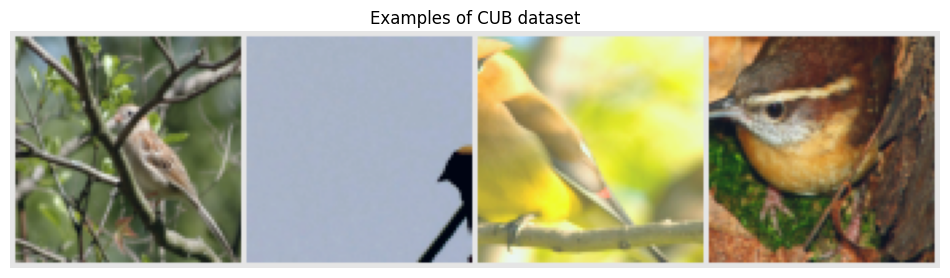

Boat tailed Grackle  |  Brewer Blackbird  |  Brown Creeper     |  Clark Nutcracker


In [10]:
img_grid = torchvision.utils.make_grid(images, nrow=8, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Examples of CUB dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()
print('  |  '.join(f'{class_dict[labels[j]]:16s}' for j in range(NUM_IMAGES)))

## Clipped Few Shot learning in hyperbolic space

First, we set the value of hyperparameters, assigned using `Config`. The hyperparameters are set for 5-way 1-shot task (same as Notebook 2). 

Note that we train the model for 5 epochs, but to reproduce the final paper numbers, the model should be trained more.

__What's new?__

Two values are added to the `Config` to perform clipping. _First_, `do_clip` is used to show whether to use clipping or not. When `do_clip` is `False`, model will be same as Notebook2. _Second_, `r` is the hyperparameter used in $CLIP(x^E, r)$.

In [26]:
class Config:
    def __init__(self, shot=1, lr=0.001, step=50, gamma=0.8, c=0.05, model="convnet", hyperbolic = True, dim=1600,
                 query=15, way=5, validation_way=5, temperature=1, dataset="CUB", lr_decay=True, max_epoch=200, 
                 do_clip = True, r = 1.0):
        
        self.lr = lr                                  # learning rate
        self.lr_decay = lr_decay                      # Boolean, whether to perform learning rate scheduler or not
        self.step_size=step                           # Period of learning rate decay
        self.gamma = gamma                            # Multiplicative factor of learning rate decay
        self.dataset= dataset                         # Dataset name
        self.model = "convnet"                        # Name of Base Model
        self.temperature = temperature                # temperature used in calculating logits
        self.max_epoch=max_epoch                      # number of epochs

        self.c = c                                    # Curvature of the hyperbolic space
        self.hyperbolic = hyperbolic                  # Boolean, if it is hyperbolic or not
        self.dim = dim                                # dimenionality of the output vector

        self.shot = shot                              # Number of shots in Few shot learning task
        self.query = query                            #
        self.way = way                                # Number of ways in Few shot learning task
        self.validation_way = validation_way          # Number of ways in Few shot learning task for validation set

        self.do_clip = do_clip                        # Boolean, whether to perform clipping or not
        self.r = r                                    # float, hyperparameter used in CLIP(xE, r)


args = Config(dim=512, max_epoch = 5, do_clip = True, r = 1.5)

Split training and validation set based on the `Config` for few-shot learning.

In [12]:
trainset = CUB("train")
train_sampler = CategoriesSampler(trainset.label, 100, args.way, args.shot + args.query)
train_loader = DataLoader(dataset=trainset, batch_sampler=train_sampler, num_workers=8, pin_memory=True)

valset = CUB("val")
val_sampler = CategoriesSampler(valset.label, 500, args.validation_way, args.shot + args.query)
val_loader = DataLoader(dataset=valset, batch_sampler=val_sampler, num_workers=8, pin_memory=True)

In [13]:
def lorenz_factor(x, *, c=1.0, dim=-1, keepdim=False):
    """
    Parameters
    ----------
    x : tensor
        point on Klein disk
    c : float
        negative curvature
    dim : int
        dimension to calculate Lorenz factor
    keepdim : bool
        retain the last dim? (default: false)

    Returns
    -------
    tensor
        Lorenz factor
    """
    return 1 / torch.sqrt(1 - c * x.pow(2).sum(dim=dim, keepdim=keepdim))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Project a point from Klein model to Poincare model
def k2p(x, c):
    denom = 1 + torch.sqrt(1 - c * x.pow(2).sum(-1, keepdim=True))
    return x / denom

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Project a point from Poincare model to Klein model
def p2k(x, c):
    denom = 1 + c * x.pow(2).sum(-1, keepdim=True)
    return 2 * x / denom

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def poincare_mean(x, dim=0, c=1.0):
    # To calculate the mean, another model of hyperbolic space named Klein model is used.
    # 1. point is projected from Poincare model to Klein model using p2k, output x is a point in Klein model
    x = p2k(x, c)
    # 2. mean is calculated
    lamb = lorenz_factor(x, c=c, keepdim=True)
    mean = torch.sum(lamb * x, dim=dim, keepdim=True) / torch.sum(lamb, dim=dim, keepdim=True)
    # 3. Mean is projected from Klein model to Poincare model
    mean = k2p(mean, c)
    return mean.squeeze(dim)

### What is the main change on `ProtoNet`?

The main difference between the _clipped_ and _normal_ `ProtoNet` lies in the input of the `exp_map`. Therefore, when `args.do_clip` is `True`, everything should be clipped using the `clip`. This results ends in clipping the output of the `self.encoder`, which is the Euclidean embedding.

In [27]:
class ProtoNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        # Base Model: ConvNet
        self.encoder = ConvNet(z_dim=args.dim)

        # If working in Hyperbolic Space
        if args.hyperbolic:
            self.manifold = geoopt.PoincareBall(c=args.c)

    def forward(self, data_shot, data_query):
        # 1. feed data to the model
        proto = self.encoder(data_shot)

        
        # Hyperbolic Space:
        if self.args.hyperbolic:
            ###################### CLIP ######################
            if args.do_clip:
                proto = clip(proto, args.r)
            ##################################################

            # 2. encoder is Euclidean, output should be projected to Hyperboolic space using exponential map
            proto = self.manifold.expmap0(proto)
            
            if self.training:
                proto = proto.reshape(self.args.shot, self.args.way, -1)
            else:
                proto = proto.reshape(self.args.shot, self.args.validation_way, -1)

            # 3. calculate prototypes based on mean of data
            proto = poincare_mean(proto, dim=0, c=self.manifold.c.item())
            
            # 4. query if projected to hyperbolic space too
            data_query = self.encoder(data_query)
            ###################### CLIP ######################
            if args.do_clip:
                data_query = clip(data_query, args.r)
            ##################################################
            data_query = self.manifold.expmap0(data_query)
            
            # 5. Logits is calculated based on the Hyperbolic distance between data query and proto
            logits = (-self.manifold.dist(data_query[:, None, :], proto) / self.args.temperature)

        # Euclidean Space
        else:
            # 2. calculate prototypes based on mean of data
            if self.training:
                proto = proto.reshape(self.args.shot, self.args.way, -1).mean(dim=0)
            else:
                proto = proto.reshape(self.args.shot, self.args.validation_way, -1).mean(dim=0)
            
            # 3. Logits is calculated based on the Euclidean distance between data query and proto
            logits = (((self.encoder(data_query)[:, None, :] - proto)**2).sum(dim=-1) / self.args.temperature)
        return logits


model = ProtoNet(args).to(device)

Once the model is defined, it's time for the training loop. Let's first define *optimizer* and *learning rate scheduler*.

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

if args.lr_decay:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

In [16]:
# Function to calculate the accuracy given logits and groundtruth labels
def count_acc(logits, label):
    pred = torch.argmax(logits, dim=1)
    if torch.cuda.is_available():
        return (pred == label).type(torch.cuda.FloatTensor).mean().item()
    else:
        return (pred == label).type(torch.FloatTensor).mean().item()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Class defined to average the values passed to it
class Averager:
    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v

#### Training loop
Next step is training the model.

In [29]:
for epoch in range(1, args.max_epoch + 1):
    if args.lr_decay:
        lr_scheduler.step()
    model.train()
    
    tl = Averager()
    ta = Averager()

    label = torch.arange(args.way).repeat(args.query)
    if torch.cuda.is_available():
        label = label.type(torch.cuda.LongTensor)
    else:
        label = label.type(torch.LongTensor)

    for i, batch in enumerate(train_loader, 1):
        if torch.cuda.is_available():
            data, _ = [_.cuda() for _ in batch]
        else:
            data = batch[0]
        p = args.shot * args.way
        data_shot, data_query = data[:p], data[p:]
        logits = model(data_shot, data_query)
        loss = F.cross_entropy(logits, label)
        acc = count_acc(logits, label)
        
        if (i == 1) or (i == len(train_loader)): 
            print("epoch {}, train {}/{}, loss={:.4f} acc={:.4f}".format(epoch, i, len(train_loader), loss.item(), acc))
        
        tl.add(loss.item())
        ta.add(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    tl = tl.item()
    ta = ta.item()

    model.eval()

    vl = Averager()
    va = Averager()

    label = torch.arange(args.validation_way).repeat(args.query)
    if torch.cuda.is_available():
        label = label.type(torch.cuda.LongTensor)
    else:
        label = label.type(torch.LongTensor)
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader, 1):
            if torch.cuda.is_available():
                data, _ = [_.cuda() for _ in batch]
            else:
                data = batch[0]
            p = args.shot * args.validation_way
            data_shot, data_query = data[:p], data[p:]
            logits = model(data_shot, data_query)
            loss = F.cross_entropy(logits, label)
            acc = count_acc(logits, label)

            vl.add(loss.item())
            va.add(acc)

    vl = vl.item()
    va = va.item()
    print("epoch {}, val, loss={:.4f} acc={:.4f}".format(epoch, vl, va))

epoch 1, train 1/100, loss=1.5794 acc=0.2933
epoch 1, train 100/100, loss=1.6932 acc=0.2133
epoch 1, val, loss=1.4254 acc=0.3972
epoch 2, train 1/100, loss=1.2952 acc=0.4933
epoch 2, train 100/100, loss=1.6063 acc=0.2400
epoch 2, val, loss=1.4004 acc=0.4254
epoch 3, train 1/100, loss=1.4594 acc=0.4000
epoch 3, train 100/100, loss=1.6920 acc=0.2133
epoch 3, val, loss=1.3755 acc=0.4182
epoch 4, train 1/100, loss=1.5255 acc=0.3867
epoch 4, train 100/100, loss=1.6323 acc=0.3067
epoch 4, val, loss=1.3500 acc=0.4370
epoch 5, train 1/100, loss=1.3717 acc=0.4800
epoch 5, train 100/100, loss=1.1023 acc=0.6667
epoch 5, val, loss=1.3338 acc=0.4510


#### Testing function

Once the training is complete, it's time to see model's performance on the test split.

First, let's create test dataloader.

In [18]:
def compute_confidence_interval(data):
    """
    Compute 95% confidence interval
    :param data: An array of mean accuracy (or mAP) across a number of sampled episodes.
    :return: the 95% confidence interval for this data.
    """
    a = 1.0 * np.array(data)
    m = np.mean(a)
    std = np.std(a)
    pm = 1.96 * (std / np.sqrt(len(a)))
    return m, pm

In [19]:
test_set = CUB("test")
test_sampler = CategoriesSampler(test_set.label, 10000, args.validation_way, args.shot + args.query)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=8, pin_memory=True)

In [20]:
model.eval()

ave_acc = Averager()
test_acc_record = np.zeros((10000,))

label = torch.arange(args.validation_way).repeat(args.query)
if torch.cuda.is_available():
    label = label.type(torch.cuda.LongTensor)
else:
    label = label.type(torch.LongTensor)

# Testing loop
for i, batch in enumerate(test_loader, 1):
    if torch.cuda.is_available():
        data, _ = [_.cuda() for _ in batch]
    else:
        data = batch[0]
    k = args.validation_way * args.shot
    data_shot, data_query = data[:k], data[k:]

    logits = model(data_shot, data_query)
    acc = count_acc(logits, label)
    ave_acc.add(acc)
    test_acc_record[i - 1] = acc

m, pm = compute_confidence_interval(test_acc_record)
print("Test Acc {:.4f} + {:.4f}".format(m, pm))

Test Acc 0.4033 + 0.0020


In [30]:
model.eval()

ave_acc = Averager()
test_acc_record = np.zeros((10000,))

label = torch.arange(args.validation_way).repeat(args.query)
if torch.cuda.is_available():
    label = label.type(torch.cuda.LongTensor)
else:
    label = label.type(torch.LongTensor)

# Testing loop
for i, batch in enumerate(test_loader, 1):
    if torch.cuda.is_available():
        data, _ = [_.cuda() for _ in batch]
    else:
        data = batch[0]
    k = args.validation_way * args.shot
    data_shot, data_query = data[:k], data[k:]

    logits = model(data_shot, data_query)
    acc = count_acc(logits, label)
    ave_acc.add(acc)
    test_acc_record[i - 1] = acc

m, pm = compute_confidence_interval(test_acc_record)
print("Test Acc {:.4f} + {:.4f}".format(m, pm))

Test Acc 0.4160 + 0.0021


When training `ProtoNet` with hyperparameter `r = 1.5`, the performance increases from $40.33$ to $41.60$.